Train one XGBoost model to predict streamflow for all stations. Forcings are aggregated from hourly to daily to match streamflow resolution. RandomSearchCV to find good parameters.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn import metrics
from datetime import datetime, timedelta
import hydroeval
import netCDF4 as nc
import xgboost as xgb
import scipy as sp
from src import load_data, evaluate

np.random.seed(0)

time_stamp = datetime.now().strftime('%Y%m%d-%H%M%S')
time_stamp

'20190906-140352'

In [2]:
station_data_dict = load_data.load_train_test_gridded_aggregatedForcings(include_all_forcing_vars=False)

In [3]:
param_dist = {
    #'max_depth': sp.stats.randint(2, 8),
    'learning_rate': sp.stats.uniform(0.005, 0.1),
    #'gamma': sp.stats.uniform(0, 5),
    #'min_child_weight': sp.stats.randint(1, 30),
    #'subsample': sp.stats.uniform(0.5, 0.2),
    #'colsample_bytree': sp.stats.uniform(0.3, 0.7),
    #'colsample_bylevel': sp.stats.uniform(0.3, 0.7),
    'reg_alpha': sp.stats.expon(0, 20),
    'reg_lambda': sp.stats.expon(0, 20),
}

In [4]:
# Create test and train splits for each station (by time), then create predictions for each subbasin
history = 7
train_start = datetime.strptime('2010-01-01', '%Y-%m-%d') + timedelta(days=history + 1)
train_end = '2012-12-31'
test_start = datetime.strptime(train_end, '%Y-%m-%d') + timedelta(days=1)
test_end = '2014-12-31'

validation_fraction = 0.1

data = pd.DataFrame()
data = pd.concat([station_data_dict[station].reset_index() for station in station_data_dict.keys()], ignore_index=True)

data = data.join(pd.get_dummies(data['station'], prefix='station'))
print(data.shape)

train = data[(data['date'] >= train_start) & (data['date'] <= train_end)].copy()
num_validation_samples = int(validation_fraction * train.shape[0])
shuffle_indices = np.arange(train.shape[0])
np.random.shuffle(shuffle_indices)
train = train.iloc[shuffle_indices]
val, train = train.iloc[:num_validation_samples].copy(), train.iloc[num_validation_samples:].copy()

test = data[(data['date'] >= test_start) & (data['date'] <= test_end)].copy()
print('Shapes: train {}, val {}, test {}'.format(train.shape, val.shape, test.shape))

val = [(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff']), 
       (val.drop(['station', 'date', 'runoff'], axis=1), val['runoff'])]

xgb_model = xgb.XGBRegressor(n_estimators=1000, colsample_bylevel=0.8085379795312839, colsample_bytree=0.5435742710880977, gamma=4.480515316405051, max_depth=6, min_child_weight=4, subsample=0.6765019548590637, n_jobs=1, random_state=123)
m = model_selection.RandomizedSearchCV(xgb_model, param_dist, n_iter=1000, cv=2, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1, random_state=123, verbose=5)
m.fit(train.drop(['station', 'date', 'runoff'], axis=1), train['runoff'], eval_set=val, eval_metric='rmse', early_stopping_rounds=50, verbose=False)

cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])

test = test[~pd.isna(test['runoff'])]

predict = test.copy()
predict['actual'] = predict['runoff']
predict['runoff'] = np.nan
predict['runoff'] = m.predict(predict.drop(['station', 'actual', 'date', 'runoff'], axis=1))

/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


(82918, 8773)
Shapes: train (44081, 8773), val (4897, 8773), test (33580, 8773)
Fitting 2 folds for each of 1000 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 88 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 274 tasks      | elapsed: 93.7min
[Parallel(n_jobs=-1)]: Done 472 tasks      | elapsed: 141.8min
[Parallel(n_jobs=-1)]: Done 706 tasks      | elapsed: 210.4min
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed: 297.3min
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed: 384.8min
[Parallel(n_jobs=-1)]: Done 1624 tasks      | elapsed: 494.9min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 605.5min finished
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/mgauch/miniconda3/envs/gwf/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isi

    param_learning_rate param_reg_alpha param_reg_lambda  mean_test_score  \
949           0.0777241         31.1175         0.599391     -1062.581733   
631           0.0952949         67.7965         0.394548     -1070.953821   
632            0.054423         19.4602         0.251604     -1077.107046   
745           0.0813945         34.9781         0.432435     -1077.868647   
574           0.0579537         21.8727         0.131951     -1078.200306   

     mean_train_score  
949        -15.545482  
631        -14.714395  
632        -25.452170  
745        -14.780450  
574        -22.879500  
Best params: {'learning_rate': 0.07772412167354457, 'reg_alpha': 31.11751470866256, 'reg_lambda': 0.5993909134225779}
mean_train_score   -15.5455
mean_test_score    -1062.58
Name: 949, dtype: object


02GA010 	NSE: 0.37719976248585263 	MSE: 296.934679102364 (clipped to 0)
02GA018 	NSE: 0.36956263244930854 	MSE: 158.33634996768842 (clipped to 0)
02GA038 	NSE: 0.25804065355258243 	MSE: 122.08084596847267 (clipped to 0)
02GA047 	NSE: 0.173726451758755 	MSE: 64.7716038263846 (clipped to 0)
02GB001 	NSE: 0.30760175040113835 	MSE: 5199.824442218271 (clipped to 0)
02GB007 	NSE: 0.3579628114946075 	MSE: 20.0777962869206 (clipped to 0)
02GC002 	NSE: 0.5851503974519057 	MSE: 53.30943283853563 (clipped to 0)
02GC007 	NSE: 0.4176045798862513 	MSE: 17.542533069216134 (clipped to 0)
02GC010 	NSE: 0.4237204167179358 	MSE: 34.25977500784377 (clipped to 0)
02GC018 	NSE: 0.5293455611402766 	MSE: 31.87591986122125 (clipped to 0)
02GC026 	NSE: 0.5513793172340108 	MSE: 72.15289961524257 (clipped to 0)
02GD004 	NSE: 0.36004796324335775 	MSE: 35.23772598071076 (clipped to 0)
02GE007 	NSE: 0.32781194840378913 	MSE: 24.316442075800474 (clipped to 0)
02GG002 	NSE: 0.6199503755664364 	MSE: 91.66144260363326 (

../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04160600 	NSE: 0.5226275846674986 	MSE: 13.810820985079753 (clipped to 0)
04161820 	NSE: 0.39641604831487876 	MSE: 19.060003669009177 (clipped to 0)
04164000 	NSE: 0.5909269655426221 	MSE: 71.68078691444303 (clipped to 0)
04165500 	NSE: 0.604073014635695 	MSE: 177.2402458646338 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04166100 	NSE: 0.18733874605847334 	MSE: 5.959495019743255 (clipped to 0)
04166500 	NSE: 0.5834750718515683 	MSE: 14.396889390784711 (clipped to 0)
04174500 	NSE: 0.3371786973039195 	MSE: 62.685818695288674 (clipped to 0)
04176500 	NSE: 0.15656075824657123 	MSE: 576.1315991190922 (clipped to 0)
04177000 	NSE: 0.27841911858575963 	MSE: 19.44648194901921 (clipped to 0)
04193500 	NSE: 0.6180041308445974 	MSE: 27045.593753421144 (clipped to 0)
04195820 	NSE: 0.5709452013296148 	MSE: 503.62209219869294 (clipped to 0)
04196800 	NSE: 0.398412689555661 	MSE: 180.0240924356492 (clipped to 0)
04197100 	NSE: 0.49936409633291834 	MSE: 51.34742595594333 (clipped to 0)
04198000 	NSE: 0.5812836277813864 	MSE: 3093.2920723276125 (clipped to 0)
04199000 	NSE: 0.4883270644107912 	MSE: 523.2384323446302 (clipped to 0)
04199500 	NSE: 0.4203602799674787 	MSE: 234.55012412465143 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04200500 	NSE: 0.486996881292478 	MSE: 513.3647632867393 (clipped to 0)
04207200 	NSE: 0.37454850275374996 	MSE: 14.639499935270706 (clipped to 0)
04208504 	NSE: 0.5805442816556057 	MSE: 409.61052895899996 (clipped to 0)
04209000 	NSE: 0.43864452724192415 	MSE: 175.51116567176607 (clipped to 0)
04212100 	NSE: 0.5811983947321183 	MSE: 614.9368826867598 (clipped to 0)
04213000 	NSE: 0.4777286215985713 	MSE: 93.73164546646841 (clipped to 0)


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evalua

04213500 	NSE: 0.6118737837589033 	MSE: 397.60303328893144 (clipped to 0)
04214500 	NSE: 0.5052534497543618 	MSE: 59.63530799712731 (clipped to 0)
04215000 	NSE: 0.39072849869013426 	MSE: 58.52224147176202 (clipped to 0)
04215500 	NSE: 0.49340697502111397 	MSE: 91.48305660601241 (clipped to 0)
Median NSE (clipped to 0) 0.4722345372406194 / Min 0.15656075824657123 / Max 0.6406607000475545
Median MSE (clipped to 0) 77.55162475463007 / Min 5.959495019743255 / Max 27045.593753421144


../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))
../../src/evaluate.py:70: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(17,4))


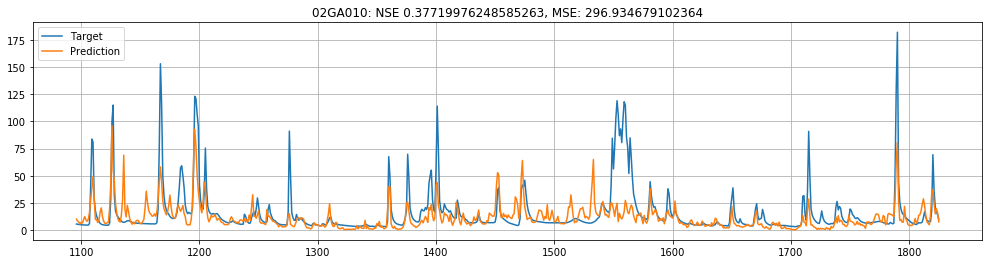

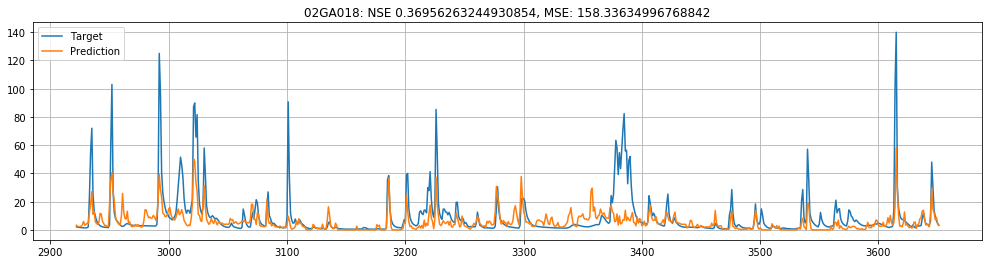

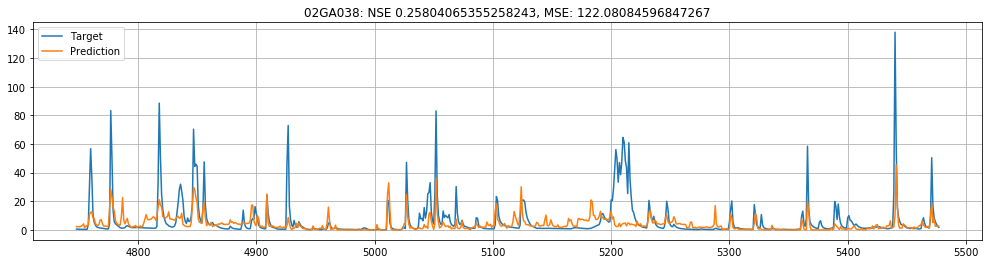

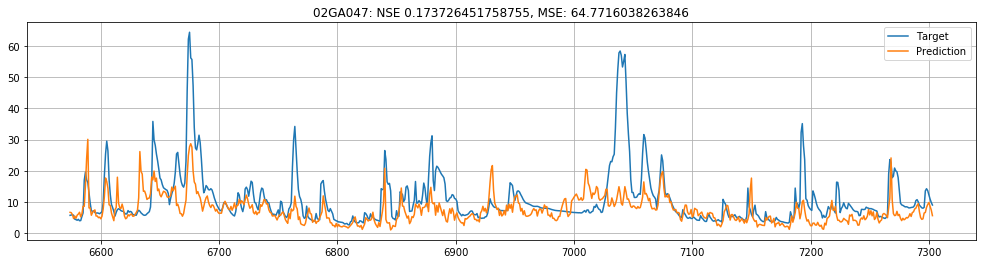

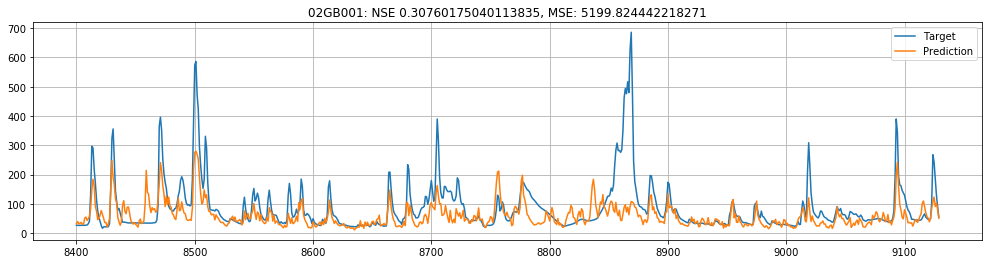

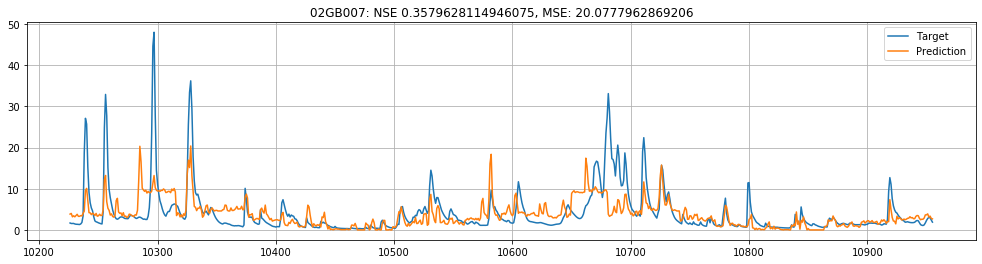

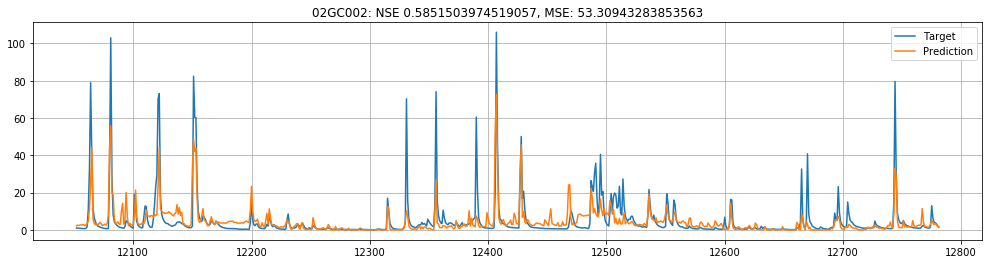

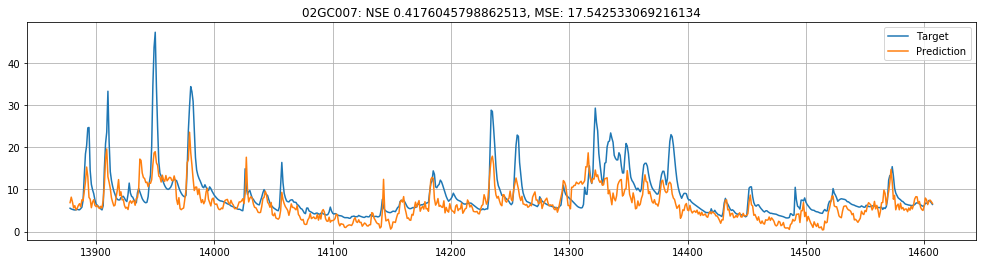

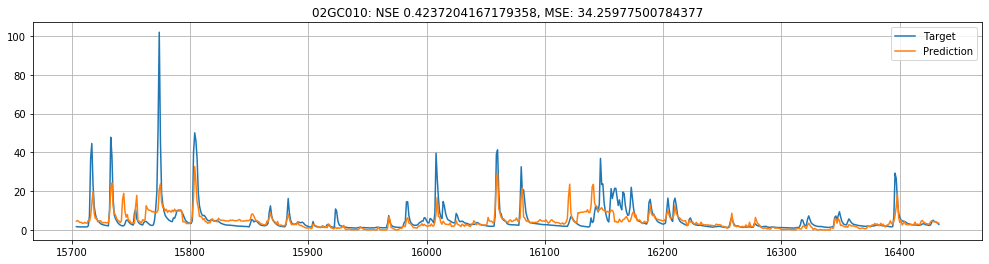

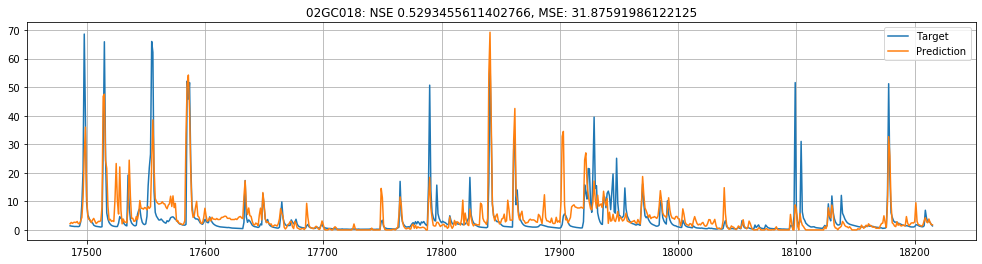

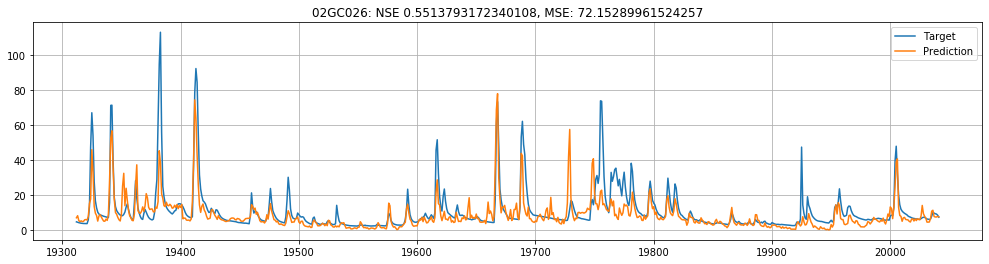

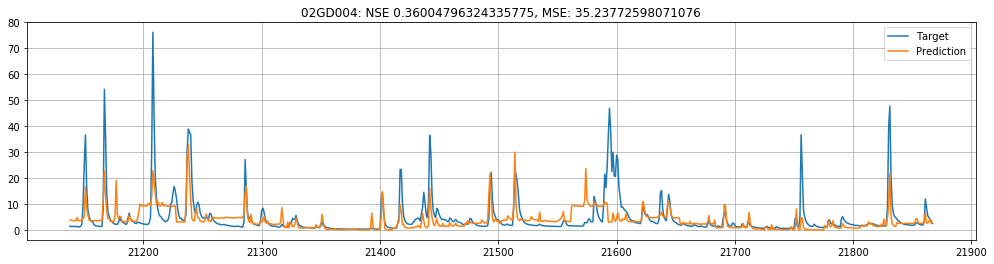

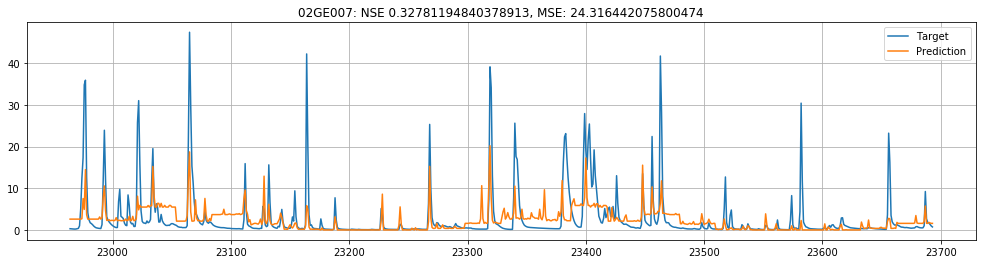

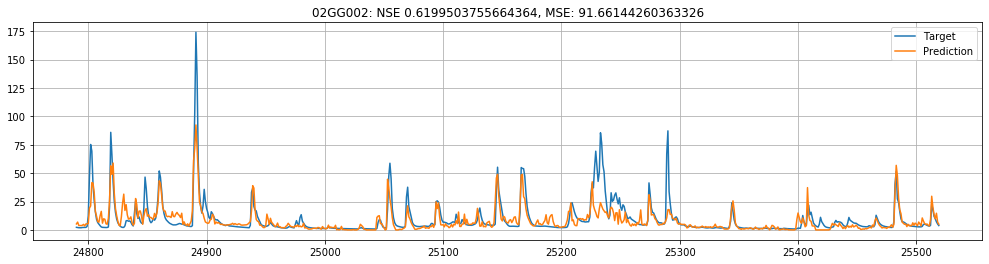

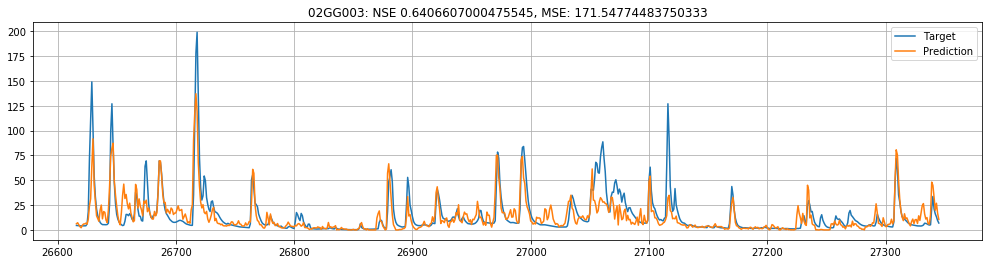

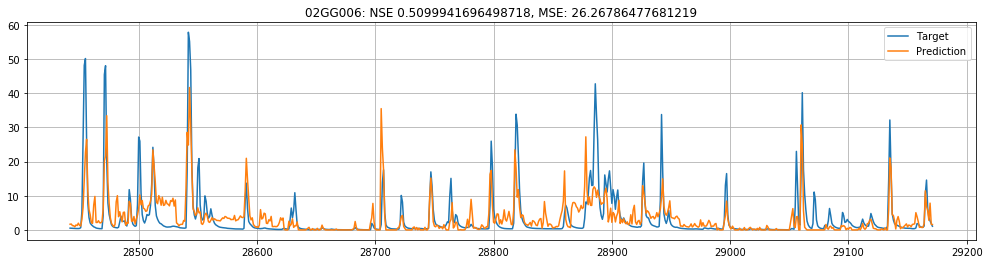

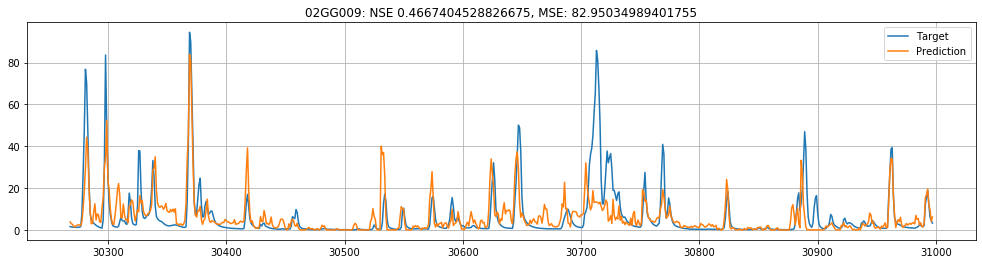

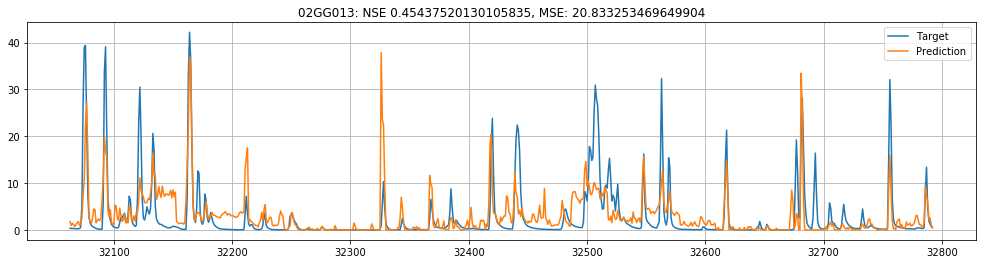

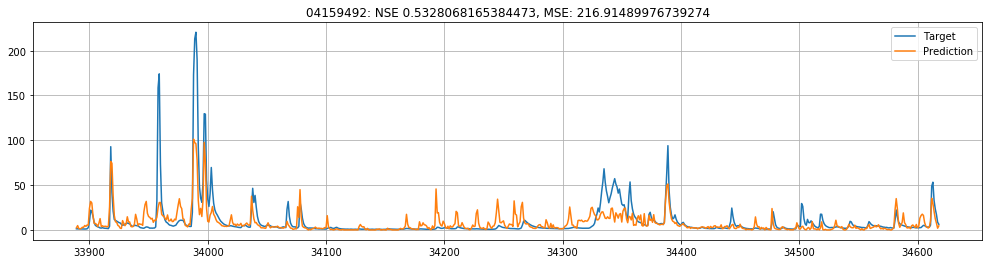

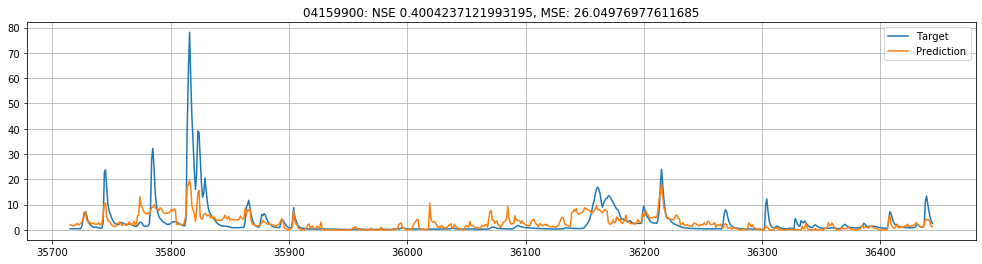

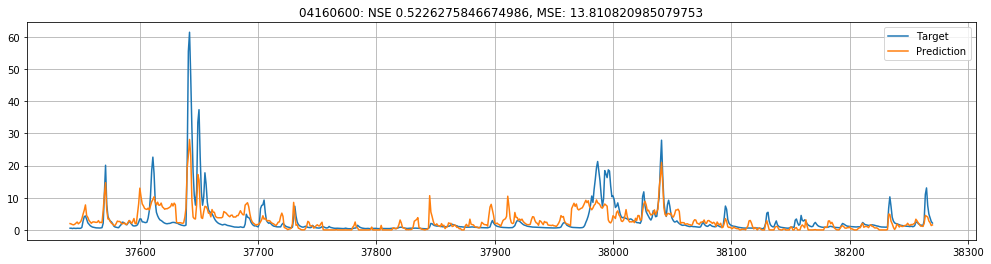

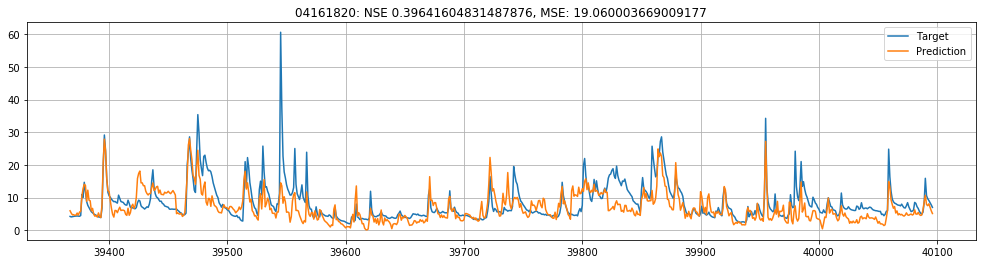

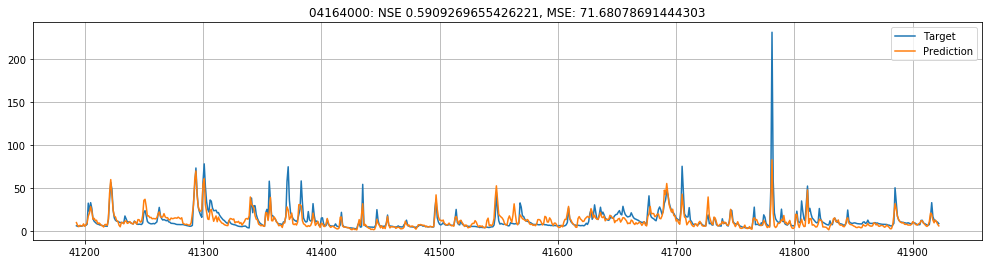

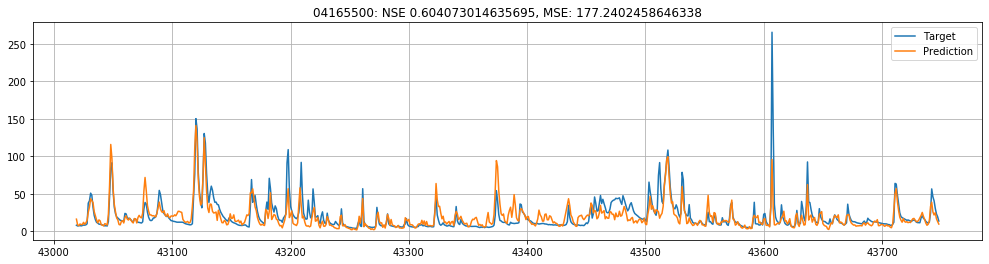

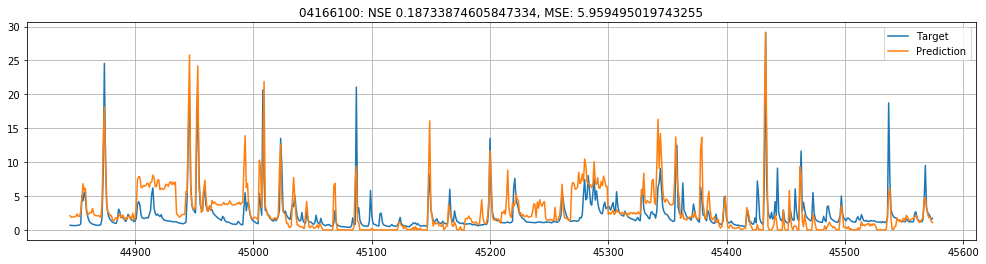

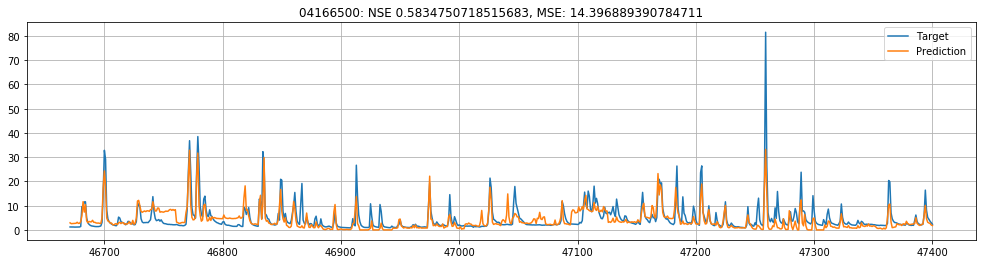

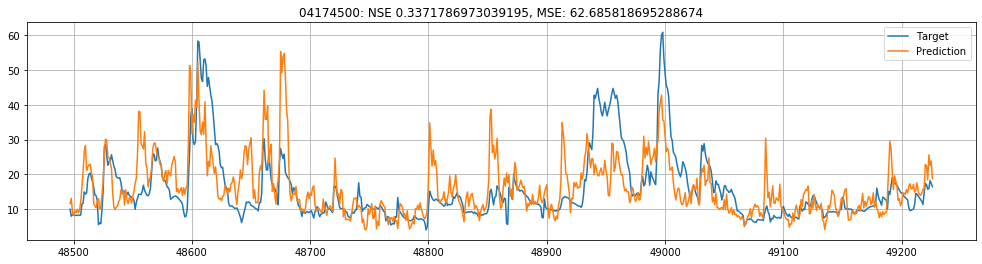

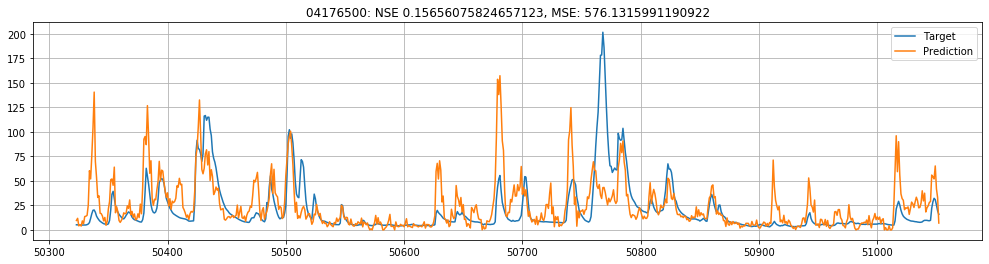

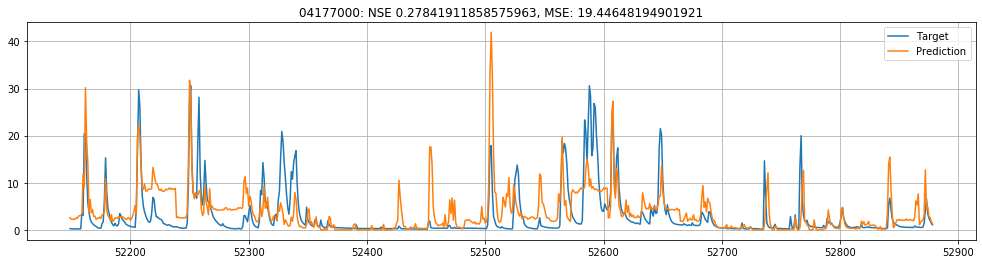

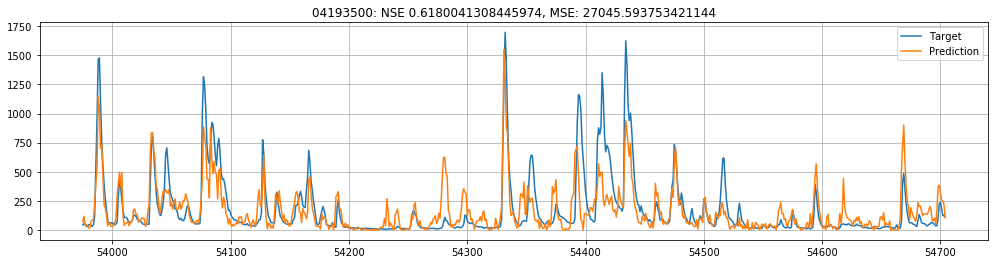

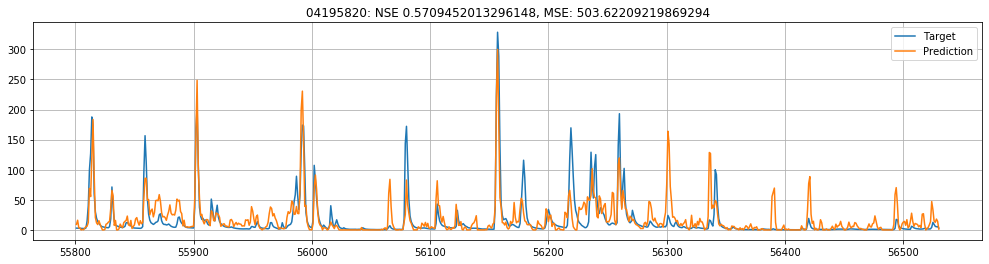

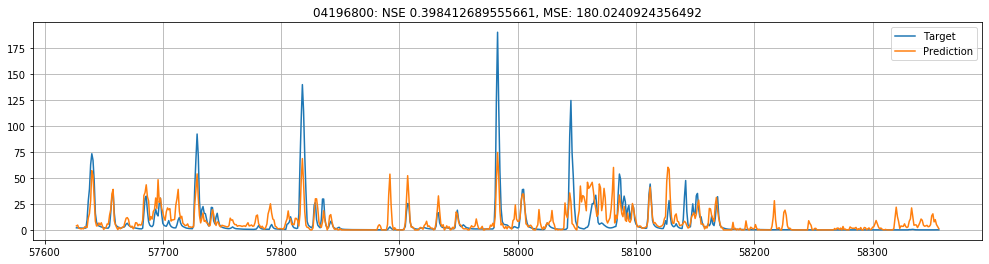

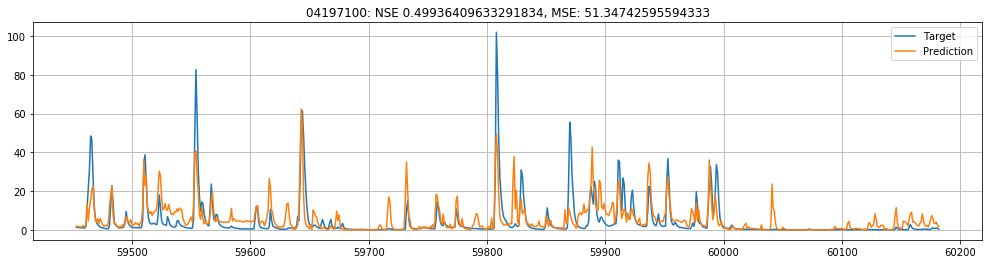

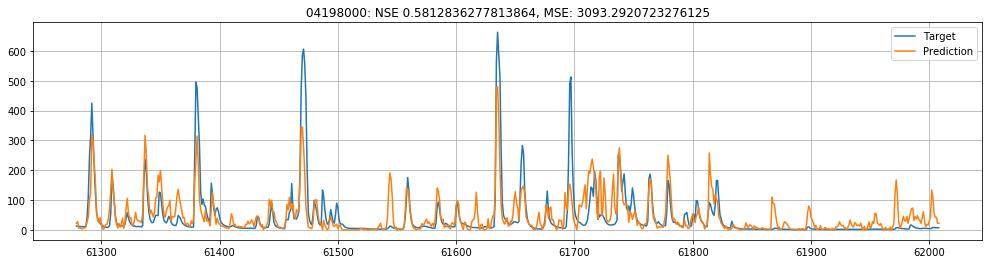

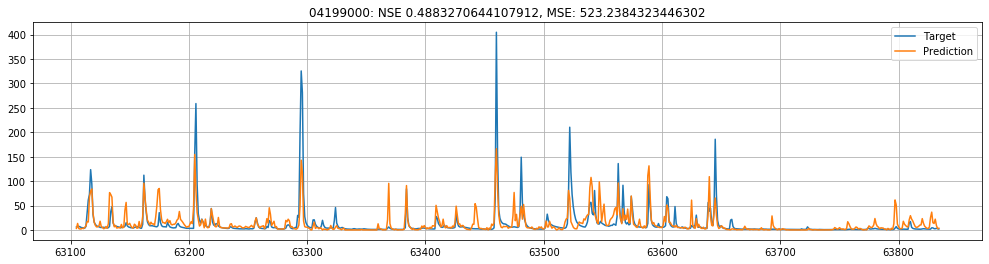

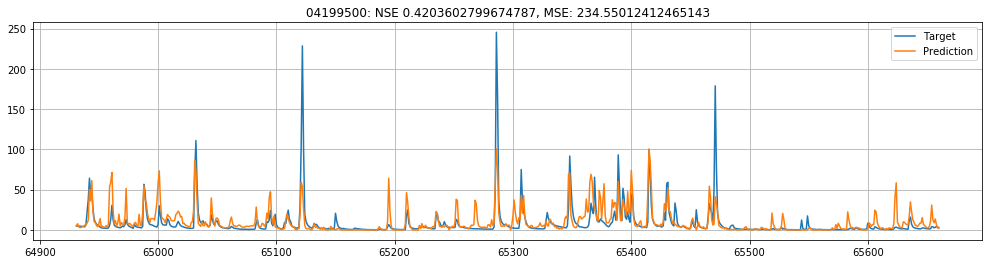

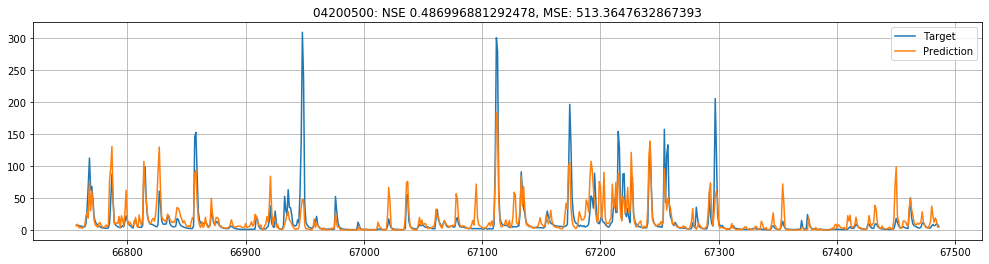

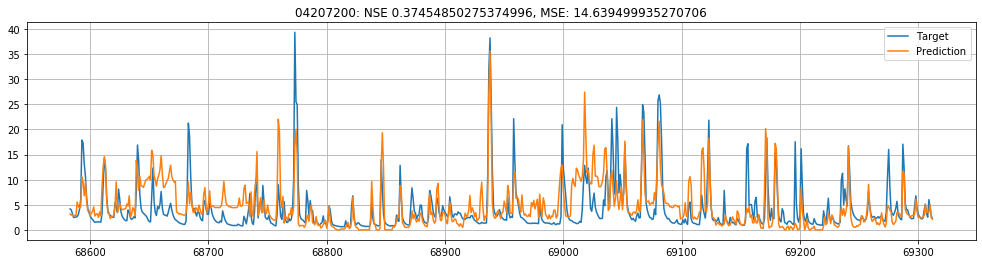

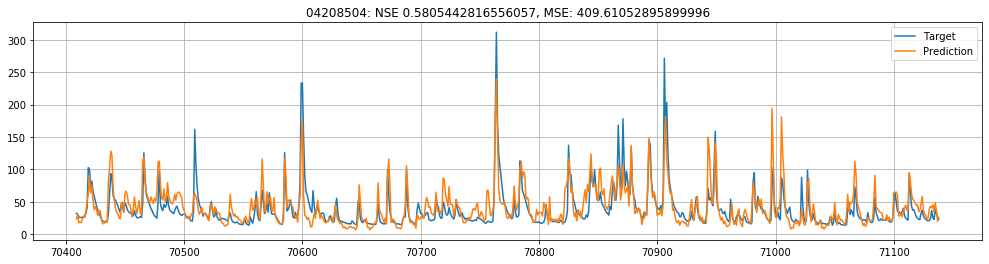

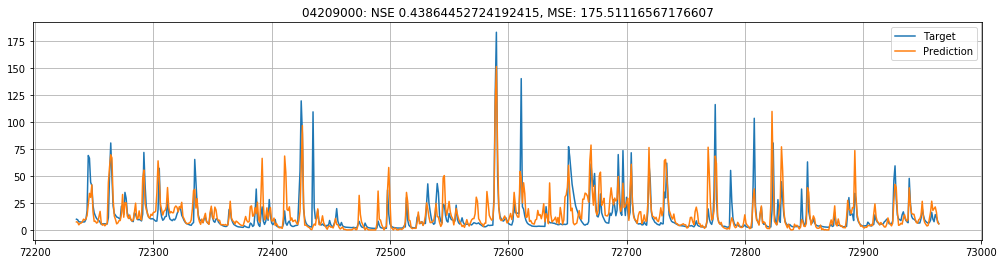

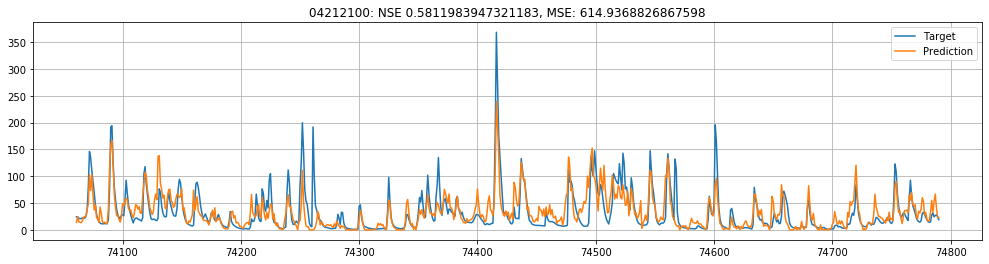

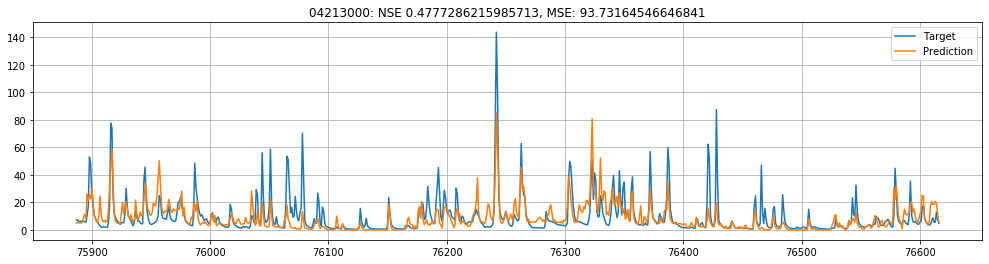

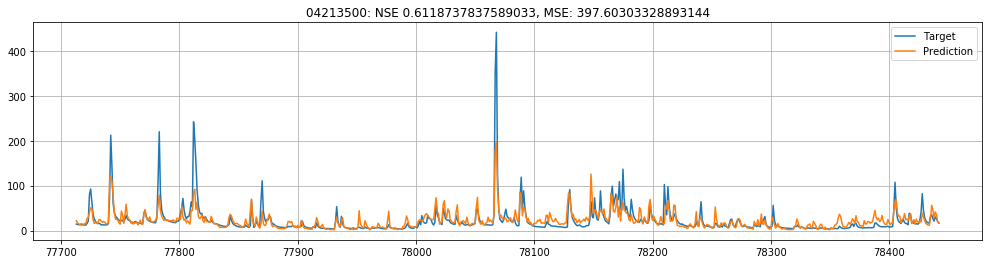

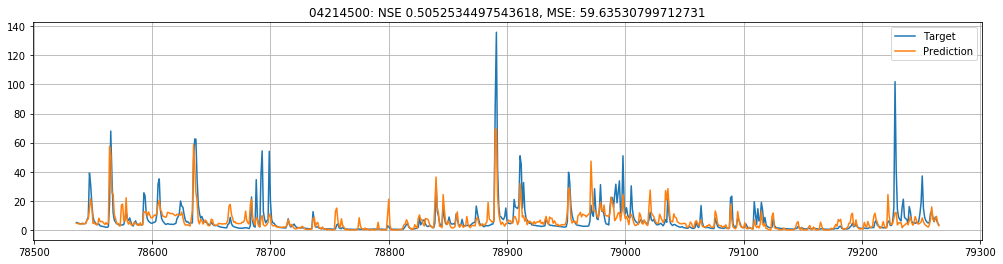

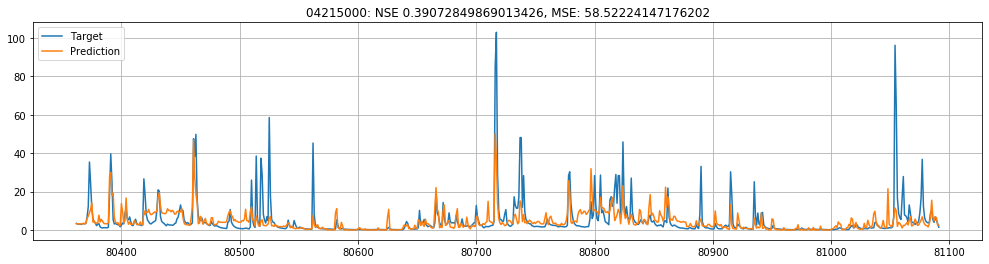

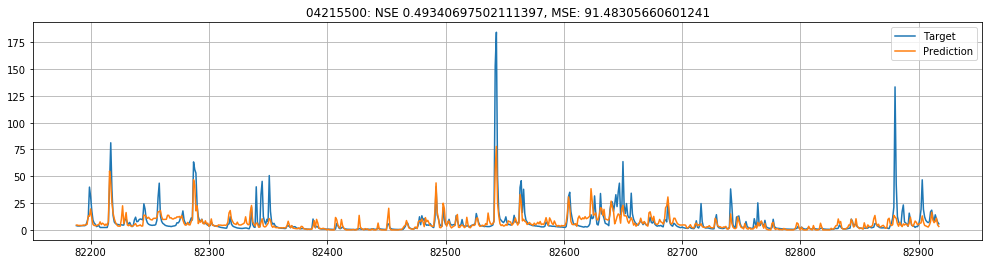

In [5]:
nse_list = []
mse_list = []
grouped_predict = predict.groupby('station')
for station in grouped_predict.groups.keys():
    station_predict = grouped_predict.get_group(station)
    nse, mse = evaluate.evaluate_daily(station, station_predict[['runoff']], station_predict['actual'], plot=True)
    nse_list.append(nse)
    mse_list.append(mse)
    
    print(station, '\tNSE:', nse, '\tMSE:', mse, '(clipped to 0)')

print('Median NSE (clipped to 0)', np.median(nse_list), '/ Min', np.min(nse_list), '/ Max', np.max(nse_list))
print('Median MSE (clipped to 0)', np.median(mse_list), '/ Min', np.min(mse_list), '/ Max', np.max(mse_list))

In [6]:
load_data.pickle_results('XGBoost_VIC_aggregateForcings_oneModel', predict[['date', 'station', 'runoff', 'actual']].rename({'runoff': 'prediction'}, axis=1).reset_index(drop=True), time_stamp)

'XGBoost_VIC_aggregateForcings_oneModel_20190906-140352.pkl'

In [7]:
load_data.pickle_model('XGBoost_VIC_aggregateForcings_oneModel', m, 'all', time_stamp, model_type='sklearn')

Saved model as /home/mgauch/runoff-nn/src/../pickle/models/XGBoost_VIC_aggregateForcings_oneModel_all_20190906-140352.pkl


In [8]:
import pickle
m=pickle.load(open('../../pickle/models/XGBoost_VIC_aggregateForcings_oneModel_all_20190905-142252.pkl', 'rb'))

In [9]:
m

RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=nan, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=123, reg_alpha=0,...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3118b47e10>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen o

In [10]:
import pandas as pd
cv_results = pd.DataFrame(m.cv_results_).sort_values(by='mean_test_score', ascending=False)
print(cv_results.filter(regex='param_|mean_test_score|mean_train_score', axis=1).head())
print('Best params: {}'.format(m.best_params_))
print(cv_results.loc[m.best_index_, ['mean_train_score', 'mean_test_score']])


      param_colsample_bylevel param_colsample_bytree param_gamma  \
8866                 0.808538               0.543574     4.48052   
13823                0.857506               0.466189    0.706341   
19995                0.955113               0.924788    0.256956   
6111                 0.787372               0.927019    0.136254   
1544                 0.790931               0.965674     3.32647   

      param_max_depth param_min_child_weight param_subsample  mean_test_score  \
8866                6                      4        0.676502     -1227.584768   
13823               7                      3        0.600078     -1240.247567   
19995               7                      5        0.638195     -1253.447002   
6111                7                      2        0.608749     -1254.028106   
1544                7                      4        0.529489     -1255.554599   

       mean_train_score  
8866        -221.117401  
13823       -190.836710  
19995       -202.260027  
